In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import sklearn 
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import catboost
import lightgbm
import xgboost
import json 

In [10]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures

In [17]:
act_test = pd.read_csv('data/data_test_v6_1.csv')
act_train = pd.read_csv('data/data_train_v6_1.csv')

In [5]:
data_test = pd.read_csv('data/dota2_csv/dota2_skill_test.csv', index_col='id')
data_train = pd.read_csv('data/dota2_csv/dota2_skill_train.csv', index_col='id')

abilities = pd.read_csv('data/dota2_csv/dota2_abilities.csv', index_col='ability_id')
heroes = pd.read_csv('data/heroes_v1.csv', index_col='hero_id')
items = pd.read_csv('data/dota2_csv/dota2_items.csv')

# V_1

_hero_-_id to dummy encoding_

In [8]:
for hero_id in set(data_train.hero_id):
    data_train['is_hero_{}'.format(hero_id)] = data_train.hero_id == hero_id
    data_test['is_hero_{}'.format(hero_id)] = data_test.hero_id == hero_id

_count behavior ability_

In [9]:
abilities.behavior = abilities.behavior.apply(
    lambda x: x.split("'")).apply(lambda x: x[1] if len(x) > 1 else 'empty')

In [ ]:
for ability_behavior in set(abilities.behavior.fillna('empty')):
    data_train['upgrade_behavior {}'.format(ability_behavior)] = 0
    data_test['upgrade_behavior {}'.format(ability_behavior)] = 0
    
with open('data/dota2_json/dota2_skill_train.jsonlines') as fin:
    for line in tqdm_notebook(fin):
        record = json.loads(line)
        for ability_upgrade in record['ability_upgrades']:
            data_train.loc[record['id'], 'upgrade_behavior {}'.format(
                abilities.loc[ability_upgrade, 'behavior'])] += 1
            
with open('data/dota2_json/dota2_skill_test.jsonlines') as fin:
    for line in tqdm_notebook(fin):
        record = json.loads(line)
        for ability_upgrade in record['ability_upgrades']:
            data_test.loc[record['id'], 'upgrade_behavior {}'.format(
                abilities.loc[ability_upgrade, 'behavior'])] += 1

#### is aegis add

In [42]:
aegis_ids_train = pd.read_csv('data/aegis_ids_train.csv')
aegis_ids_test = pd.read_csv('data/aegis_ids_test.csv')

In [43]:
aegis_ids_train.columns, aegis_ids_test.columns  = ['ind','id'],  ['ind','id']

In [44]:
for id_t in act_train.index:
    if id_t in aegis_ids_train['id']:
        act_train.loc[id_t, 'is_aegis'] = 1
    else:
        act_train.loc[id_t, 'is_aegis'] = 0

In [45]:
for id_t in act_test.index:
    if id_t in aegis_ids_test['id']:
        act_test.loc[id_t, 'is_aegis'] = 1
    else:
        act_test.loc[id_t, 'is_aegis'] = 0

#### add heroes info

In [46]:
heroes_add = heroes.iloc[:,-10:-1]
act_train = pd.merge(act_train, heroes_add, on=['hero_id'])
act_test = pd.merge(act_test, heroes_add, on=['hero_id'])

#### add items for train

In [23]:
train_items_qual_count = pd.read_csv('data/train_items_qual_count.csv')

In [25]:
train_items_qual_count.shape

(99871, 8)

In [56]:
train_items_qual_count.columns = ['id', 'qual_item_component_count', 'qual_item_rare_count',
       'qual_item_epic_count', 'qual_item_consumable_count',
       'qual_item_artifact_count', 'qual_item_common_count',
       'qual_item_secret_shop_count']

In [58]:
act_train = pd.merge(act_train, train_items_qual_count, on = 'id')

test

In [26]:
test_items_qual_count = pd.read_csv('data/test_items_qual_count.csv')

In [27]:
test_items_qual_count.shape

(43265, 8)

In [78]:
test_items_qual_count.columns = ['id', 'qual_item_component_count', 'qual_item_rare_count',
       'qual_item_epic_count', 'qual_item_consumable_count',
       'qual_item_artifact_count', 'qual_item_common_count',
       'qual_item_secret_shop_count']

In [81]:
act_test = pd.merge(act_test, test_items_qual_count, on = 'id')

In [83]:
act_test.shape

(43265, 200)

# V_2

In [6]:
train_final_items_qual_and_cost = pd.read_csv('data/train_final_items_qual_and_cost.csv')

In [10]:
train_final_items_qual_and_cost.columns = ['id', 'final_items_sum', 'final_items_component',
       'final_items_rare', 'final_items_epic', 'final_items_consumable',
       'final_items_artifact', 'final_items_common',
       'final_items_secret_shop']

In [12]:
act_train = pd.merge(act_train, train_final_items_qual_and_cost, on='id')

_test_

In [20]:
test_final_items_qual_and_cost = pd.read_csv('data/test_final_items_qual_and_cost.csv')

In [23]:
test_final_items_qual_and_cost.columns = ['id', 'final_items_sum', 'final_items_component',
       'final_items_rare', 'final_items_epic', 'final_items_consumable',
       'final_items_artifact', 'final_items_common',
       'final_items_secret_shop']

In [24]:
act_test = pd.merge(act_test, test_final_items_qual_and_cost, on='id')

# V_3

#### level up speed

In [38]:
train_level_up = pd.read_csv('data/train_level_up.csv')
train_level_up.columns = ['id', 'level_up_speed']
act_train = pd.merge(act_train, train_level_up, on='id')

In [45]:
test_level_up = pd.read_csv('data/test_level_up.csv')
test_level_up.columns = ['id', 'level_up_speed']
act_test = pd.merge(act_test, test_level_up, on='id')

# V_4

In [2]:
train_id_damage_targets = pd.read_csv('data/train_id_damage_targets.csv')
train_id_damage_targets = train_id_damage_targets.rename(columns = {'Unnamed: 0':'id'})
# act_train = pd.merge(act_train, train_id_damage_targets, on='id')

_test_

In [7]:
test_id_damage_targets = pd.read_csv('data/test_id_damage_targets.csv')
test_id_damage_targets = test_id_damage_targets.rename(columns = {'Unnamed: 0':'id'})
#act_test = pd.merge(act_test, test_id_damage_targets[train_id_damage_targets.columns], on='id')

# V_5 add old heroes

In [41]:
heroes = heroes[['agi_gain',
 'base_armor',
 'base_attack_max',
 'base_attack_min',
 'base_health_regen',
 'int_gain',
 'move_speed',
 'str_gain']]

In [42]:
heroes_add = heroes
act_train = pd.merge(act_train, heroes_add, on=['hero_id'])
act_test = pd.merge(act_test, heroes_add, on=['hero_id'])

In [22]:
# act_train = act_train.drop([ 'winrate_y', 'Carry_y', 'Escape_y', 'Nuker_y', 'Initiator_y', 'Durable_y', 'Disabler_y','Jungler_y', 'Support_y'],axis=1)
# act_test = act_test.drop([ 'winrate_y', 'Carry_y', 'Escape_y', 'Nuker_y', 'Initiator_y', 'Durable_y', 'Disabler_y','Jungler_y', 'Support_y'],axis=1)

In [29]:
# act_train = act_train.drop(['name', 'localized_name', 'roles'],axis=1)
# act_test = act_test.drop(['name', 'localized_name', 'roles'],axis=1)

In [31]:
# act_train["attack_type"] = LabelEncoder().fit_transform(act_train["attack_type"])
# act_test["attack_type"] = LabelEncoder().fit_transform(act_test["attack_type"])

# act_train["primary_attr"] = LabelEncoder().fit_transform(act_train["primary_attr"])
# act_test["primary_attr"] = LabelEncoder().fit_transform(act_test["primary_attr"])

# V5_2

_train_

In [5]:
train_series = pd.read_csv('data/train_series.csv')
train_series.columns = ['id', 'p_sum', 'p_mean', 'p_std', 't_sum', 't_mean', 't_std', 'delta_sum', 'delta_mean', 'delta_std']
act_train = pd.merge(act_train, train_series, on=['id'])

_test_

In [17]:
test_series = pd.read_csv('data/test_series.csv')
test_series.columns = ['id', 'p_sum', 'p_mean', 'p_std', 't_sum', 't_mean', 't_std',
       'delta_sum', 'delta_mean', 'delta_std']
act_test = pd.merge(act_test, test_series, on=['id'])

# V5_3

team heroes 

In [20]:
train_teammates = pd.read_csv('data/train_teammates.csv')
a = ['id'] + ['teammate_{}_hero'.format(i) for i in list(range(0,117))]
train_teammates.columns = a
act_train = pd.merge(act_train, train_teammates, on=['id'])

In [47]:
test_teammates = pd.read_csv('data/test_teammates.csv')
a = ['id'] + ['teammate_{}_hero'.format(i) for i in list(range(0,117))]
test_teammates.columns = a
act_test = pd.merge(act_test, test_teammates, on=['id'])

# V6

_train_

In [4]:
train_tm_stats = pd.read_csv('data/train_tm_stats.csv')
train_tm_stats.columns = ['id','tm_agi_mean','tm_attack_range_mean','tm_attack_rate_mean ','tm_winrate_mean','tm_agi_std','tm_attack_range_std','tm_attack_rate_std ','tm_winrate_std', 'tm_Carry', 'tm_Escape', 'tm_Nuker', 'tm_Initiator', 'tm_Durable', 'tm_Disabler','tm_Jungler', 'tm_Support', 'tm_Pusher']
act_train = pd.merge(act_train, train_tm_stats, on=['id'])

_test_

In [15]:
test_tm_stats = pd.read_csv('data/test_tm_stats.csv')
test_tm_stats.columns = ['id','tm_agi_mean','tm_attack_range_mean','tm_attack_rate_mean ','tm_winrate_mean','tm_agi_std','tm_attack_range_std','tm_attack_rate_std ','tm_winrate_std', 'tm_Carry', 'tm_Escape', 'tm_Nuker', 'tm_Initiator', 'tm_Durable', 'tm_Disabler','tm_Jungler', 'tm_Support', 'tm_Pusher']
act_test = pd.merge(act_test, test_tm_stats, on=['id'])

# V6_1 with heroes info

In [13]:
heroes = heroes.drop(['name', 'localized_name', 'roles'],axis=1)

In [19]:
heroes["attack_type"] = LabelEncoder().fit_transform(heroes["attack_type"])
heroes["primary_attr"] = LabelEncoder().fit_transform(heroes["primary_attr"])

In [25]:
heroes = heroes[list(set(heroes.columns) - set(act_train.columns))]

In [33]:
act_train = pd.merge(act_train, heroes, on=['hero_id'])

In [37]:
act_test = pd.merge(act_test, heroes, on=['hero_id'])

# V7_1

In [7]:
df = pd.read_csv('data/deltas_p_team.csv')
df.columns = ['id', 'p_team_delta_skilled', 'p_team_delta_gold_per_min', 'p_team_delta_xp_per_min',
'p_team_delta_avg_kills_x16' , 'p_team_delta_avg_deaths_x16',
'p_team_delta_avg_assists_x16' , 'p_team_delta_avg_gpm_x16',
'p_team_delta_avg_xpm_x16', 'p_team_delta_best_kills_x16',
'p_team_delta_best_assists_x16', 'p_team_delta_best_gpm_x16',
'p_team_delta_best_xpm_x16', 'p_team_delta_win_streak',
'p_team_delta_best_win_streak']

In [8]:
df.columns = ['id', 'p_team_delta_skilled', 'p_team_delta_gold_per_min', 'p_team_delta_xp_per_min',
'p_team_delta_avg_kills_x16' , 'p_team_delta_avg_deaths_x16',
'p_team_delta_avg_assists_x16' , 'p_team_delta_avg_gpm_x16',
'p_team_delta_avg_xpm_x16', 'p_team_delta_best_kills_x16',
'p_team_delta_best_assists_x16', 'p_team_delta_best_gpm_x16',
'p_team_delta_best_xpm_x16', 'p_team_delta_win_streak',
'p_team_delta_best_win_streak']

In [9]:
df1 = pd.read_csv('data/data_train_v7.csv')

In [17]:
df1 = df1[['id','delta_skilled', 'delta_gold_per_min', 'delta_xp_per_min', 'delta_avg_kills_x16', 'delta_avg_deaths_x16', 'delta_avg_assists_x16', 'delta_avg_gpm_x16', 'delta_avg_xpm_x16', 'delta_best_kills_x16', 'delta_best_assists_x16', 'delta_best_gpm_x16', 'delta_best_xpm_x16', 'delta_win_streak', 'delta_best_win_streak']]

In [19]:
df.head()

,id,delta_skilled,delta_gold_per_min,delta_xp_per_min,delta_avg_kills_x16,delta_avg_deaths_x16,delta_avg_assists_x16,delta_avg_gpm_x16,delta_avg_xpm_x16,delta_best_kills_x16,delta_best_assists_x16,delta_best_gpm_x16,delta_best_xpm_x16,delta_win_streak,delta_best_win_streak
0,7,0.119202,272.254871,86.744282,4.876995,1.560044,0.000000,185.831098,118.829935,12.671473,1.432983,302.002789,152.439229,0.238277,1.345000
1,8,0.022589,297.587434,274.052825,5.036999,0.568972,0.000000,243.908889,204.928384,12.904838,1.648354,346.613503,230.673023,0.000000,0.832502
2,12,0.130380,46.469036,88.967875,1.008085,2.658222,4.868259,24.589097,41.556299,7.449741,9.120948,120.613715,124.212064,0.000000,1.445016
3,13,0.105424,45.991579,0.000000,0.832700,2.873910,5.591272,72.586003,27.626730,0.000000,2.610796,19.403087,0.000000,0.365985,0.000000
4,14,0.175358,212.417312,165.797390,0.000000,0.000000,2.131637,177.080305,113.247327,0.000000,1.371088,107.577811,0.000000,0.000000,0.000000


In [20]:
df1.head()

,id,delta_skilled,delta_gold_per_min,delta_xp_per_min,delta_avg_kills_x16,delta_avg_deaths_x16,delta_avg_assists_x16,delta_avg_gpm_x16,delta_avg_xpm_x16,delta_best_kills_x16,delta_best_assists_x16,delta_best_gpm_x16,delta_best_xpm_x16,delta_win_streak,delta_best_win_streak
0,7,0.119202,272.254871,86.744282,4.876995,1.560044,0.00000,185.831098,118.829935,12.671473,1.432983,302.002789,152.439229,0.238277,1.345000
1,526,0.119202,299.414314,197.312509,6.706400,0.559200,0.00000,249.140671,195.667251,18.923438,1.432983,425.532810,269.579556,0.238277,3.545564
2,531,0.076144,199.982428,182.822641,9.034535,0.216209,0.00000,164.564131,169.166766,22.259717,0.000000,286.839225,270.649607,0.222471,3.030399
3,697,0.136222,161.106363,127.496176,9.384130,2.060304,1.34179,151.089644,153.551660,19.878382,2.342948,235.843387,214.670728,0.410451,2.099169
4,2220,0.104167,251.267081,264.344901,8.442439,2.406638,0.00000,213.499208,170.401910,19.514681,4.011394,366.172155,242.715607,0.228972,3.453040


<hr>

# Save new dataset

In [33]:
act_train.to_csv('data/data_train_v7_1.csv')

In [40]:
act_test.to_csv('data/data_test_v6_1.csv')

# Explore new data

In [5]:
df = pd.read_csv('data/data_train_v6_1.csv')

_heat map_

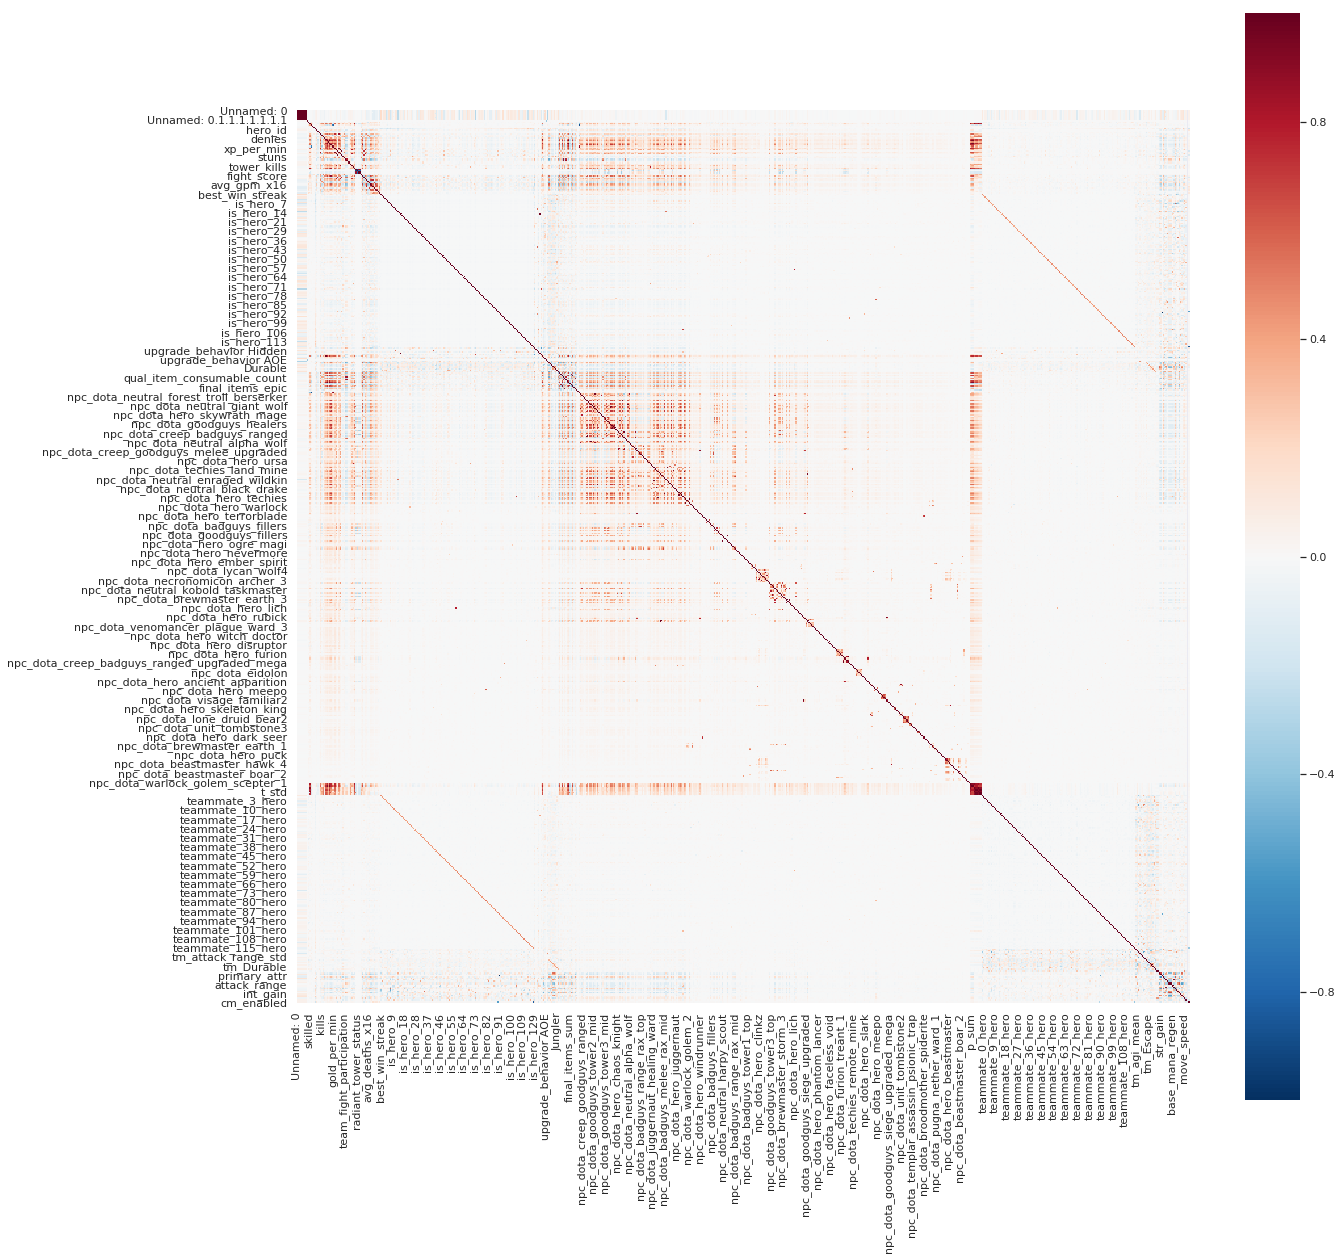

In [6]:
plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(),square=True,center=0, cmap='RdBu_r')
plt.show()

In [7]:
co = df.corr()

In [3]:
import numpy as np

In [8]:
np.nan

nan